In [1]:
import pandas as pd
import json
import cv2
import numpy as np
import matplotlib.pyplot as plt

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

In [2]:
df = pd.read_csv('./project-9-at-2023-03-24-09-49-a840689c.csv', sep='\t')
df.label = df.label.apply(json.loads)
df = df[(df.label.apply(lambda x: len(x[0]['points'])) == 4)]
len(df)

333

In [3]:
def load_image(image_path):
    image = cv2.imread(image_path.replace('/data/local-files/?d=', '../data/'))
    return image

In [4]:
def get_keypoints(points):
    assert 'points' in points.keys()
    assert 'original_width' in points.keys()
    assert 'original_height' in points.keys()
    w = points['original_width']
    h = points['original_height']
    kpoints = []
    points = sorted(points['points'])
    for point in points:
        x, y = point
        kpoints.append(Keypoint(x*w/100, y*h/100))
    return KeypointsOnImage(kpoints, shape=(h,w))

In [5]:
IMG_SIZE = 224
BATCH_SIZE = 64
EPOCHS = 5
NUM_KEYPOINTS = 4 * 2

In [6]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7),)),
        iaa.PerspectiveTransform(.1),
        iaa.VerticalFlip(p=.1),
    ]
)
test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [8]:
for i, row in df.iterrows():
    kp = get_keypoints(row.label[0])

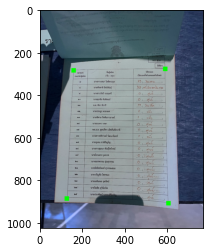

In [9]:
plt.imshow(kp.draw_on_image(load_image(row.image), size=20))

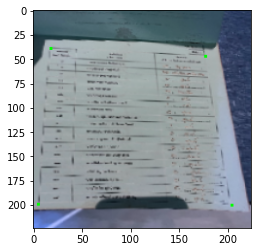

In [10]:
aimg, akp = train_aug(image=load_image(row.image), keypoints=kp)
plt.imshow(akp.draw_on_image(aimg, size=2))

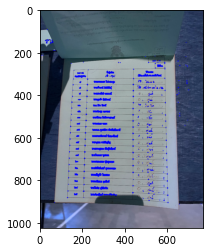

In [11]:
def corner(img):
    gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gray = np.float32(gray)
    dst = cv2.cornerHarris(gray,2,3,0.04)
    #result is dilated for marking the corners, not important
    dst = cv2.dilate(dst,None)
    # Threshold for an optimal value, it may vary depending on the image.
    img[dst>0.01*dst.max()]=[0,0,255]
    return dst

cimg = load_image(row.image)
corner(cimg)
plt.imshow(cimg)

In [12]:
import tensorflow as tf

2023-03-26 01:03:51.116746: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [13]:
class KeyPointsDataset(tf.keras.utils.Sequence):
    def __init__(self, images, keys, aug, batch_size=BATCH_SIZE, train=True):
        self.image_list = images
        self.key_list = keys
        self.aug = aug
        self.batch_size = batch_size
        self.train = train
        self.on_epoch_end()

    def __len__(self):
        return len(self.image_list) // self.batch_size

    def on_epoch_end(self):
        self.indexes = np.arange(len(self.image_list))
        if self.train:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        indexes = self.indexes[index * self.batch_size : (index + 1) * self.batch_size]
        image_keys_temp = [(self.image_list[k], self.key_list[k]) for k in indexes]
        (images, keypoints) = self.__data_generation(image_keys_temp)

        return (images, keypoints)

    def __data_generation(self, image_keys_temp):
        batch_images = np.empty((self.batch_size, IMG_SIZE, IMG_SIZE, 3), dtype="int")
        batch_keypoints = np.empty(
            (self.batch_size, 1, 1, NUM_KEYPOINTS), dtype="float32"
        )

        for i in range(self.batch_size):
            (image_fpath, keys) = image_keys_temp[i%len(image_keys_temp)]
            current_image = load_image(image_fpath)
            kps_obj = get_keypoints(keys[0])

            # Apply the augmentation pipeline.
            (new_image, new_kps_obj) = self.aug(image=current_image, keypoints=kps_obj)
            batch_images[i,] = new_image

            # Parse the coordinates from the new keypoint object.
            kp_temp = []
            for keypoint in new_kps_obj:
                kp_temp.append(np.nan_to_num(keypoint.x))
                kp_temp.append(np.nan_to_num(keypoint.y))
            # More on why this reshaping later.
            batch_keypoints[i,] = np.array(kp_temp).reshape(1, 1, 4 * 2)

        # Scale the coordinates to [0, 1] range.
        batch_keypoints = batch_keypoints / IMG_SIZE

        return (batch_images, batch_keypoints.reshape(self.batch_size, 4*2))

In [14]:
train_aug = iaa.Sequential(
    [
        iaa.Resize(IMG_SIZE, interpolation="linear"),
        iaa.Fliplr(0.3),
        iaa.Sometimes(0.3, iaa.Affine(rotate=10, scale=(0.5, 0.7),)),
        iaa.PerspectiveTransform(.1),
        iaa.VerticalFlip(p=.1),
    ]
)
test_aug = iaa.Sequential([iaa.Resize(IMG_SIZE, interpolation="linear")])

In [15]:
from sklearn.model_selection import train_test_split
x_train, x_test, y_train, y_test = train_test_split(df.image.to_list(), df.label.to_list())

In [16]:
train_dataset = KeyPointsDataset(x_train, y_train, train_aug)
validation_dataset = KeyPointsDataset(x_test, y_test, test_aug, train=False)

In [17]:
def get_model():
    # Load the pre-trained weights of MobileNetV2 and freeze the weights
    backbone = tf.keras.applications.MobileNetV2(
        weights="imagenet", include_top=False, input_shape=(IMG_SIZE, IMG_SIZE, 3)
    )
    backbone.trainable = False

    inputs = tf.keras.layers.Input((IMG_SIZE, IMG_SIZE, 3))
    x = tf.keras.applications.mobilenet_v2.preprocess_input(inputs)
    x = backbone(x)
    x = tf.keras.layers.Dropout(0.3)(x)
    
    x = tf.keras.layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=5, strides=1, activation="relu"
    )(x)
    
    x = tf.keras.layers.SeparableConv2D(
        NUM_KEYPOINTS, kernel_size=3, strides=4, activation="sigmoid"
    )(x)
    
    outputs = tf.keras.layers.Flatten()(x)

    return tf.keras.Model(inputs, outputs, name="keypoint_detector")

In [18]:
model = get_model()
model.summary()
model.compile(loss="mse", optimizer=tf.keras.optimizers.Adam(2e-3))

2023-03-26 01:04:03.155696: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Model: "keypoint_detector"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 224, 224, 3)]     0         
                                                                 
 tf.math.truediv (TFOpLambda  (None, 224, 224, 3)      0         
 )                                                               
                                                                 
 tf.math.subtract (TFOpLambd  (None, 224, 224, 3)      0         
 a)                                                              
                                                                 
 mobilenetv2_1.00_224 (Funct  (None, 7, 7, 1280)       2257984   
 ional)                                                          
                                                                 
 dropout (Dropout)           (None, 7, 7, 1280)        0         
                                                 

In [19]:
model.fit(train_dataset, epochs=200)

Epoch 1/200
3/3 [==============================] - 7s 1s/step - loss: 0.1245
Epoch 2/200
3/3 [==============================] - 5s 1s/step - loss: 0.1270
Epoch 3/200
3/3 [==============================] - 5s 1s/step - loss: 0.1239
Epoch 4/200
3/3 [==============================] - 5s 1s/step - loss: 0.1229
Epoch 5/200
3/3 [==============================] - 5s 1s/step - loss: 0.1324
Epoch 6/200
3/3 [==============================] - 5s 1s/step - loss: 0.1155
Epoch 7/200
3/3 [==============================] - 5s 1s/step - loss: 0.1167
Epoch 8/200
3/3 [==============================] - 8s 3s/step - loss: 0.1147
Epoch 9/200
3/3 [==============================] - 7s 2s/step - loss: 0.1178
Epoch 10/200
3/3 [==============================] - 6s 2s/step - loss: 0.1017
Epoch 11/200
3/3 [==============================] - 6s 2s/step - loss: 0.1054
Epoch 12/200
3/3 [==============================] - 6s 2s/step - loss: 0.1028
Epoch 13/200
3/3 [==============================] - 6s 2s/step - loss: 0.

3/3 [==============================] - 6s 2s/step - loss: 0.0356
Epoch 107/200
3/3 [==============================] - 6s 2s/step - loss: 0.0380
Epoch 108/200
3/3 [==============================] - 6s 2s/step - loss: 0.0341
Epoch 109/200
3/3 [==============================] - 6s 2s/step - loss: 0.0336
Epoch 110/200
3/3 [==============================] - 6s 2s/step - loss: 0.0416
Epoch 111/200
3/3 [==============================] - 6s 2s/step - loss: 0.0347
Epoch 112/200
3/3 [==============================] - 6s 2s/step - loss: 0.0315
Epoch 113/200
3/3 [==============================] - 6s 2s/step - loss: 0.0431
Epoch 114/200
3/3 [==============================] - 6s 2s/step - loss: 0.0355
Epoch 115/200
3/3 [==============================] - 6s 2s/step - loss: 0.0342
Epoch 116/200
3/3 [==============================] - 6s 2s/step - loss: 0.0371
Epoch 117/200
3/3 [==============================] - 6s 2s/step - loss: 0.0341
Epoch 118/200
3/3 [==============================] - 6s 2s/step - 

KeyboardInterrupt: 

In [25]:
validation_dataset.on_epoch_end()
images, y_true = validation_dataset[0]
y_preds = model.predict(images).reshape(-1, 4, 2)

2/2 [==============================] - 1s 667ms/step


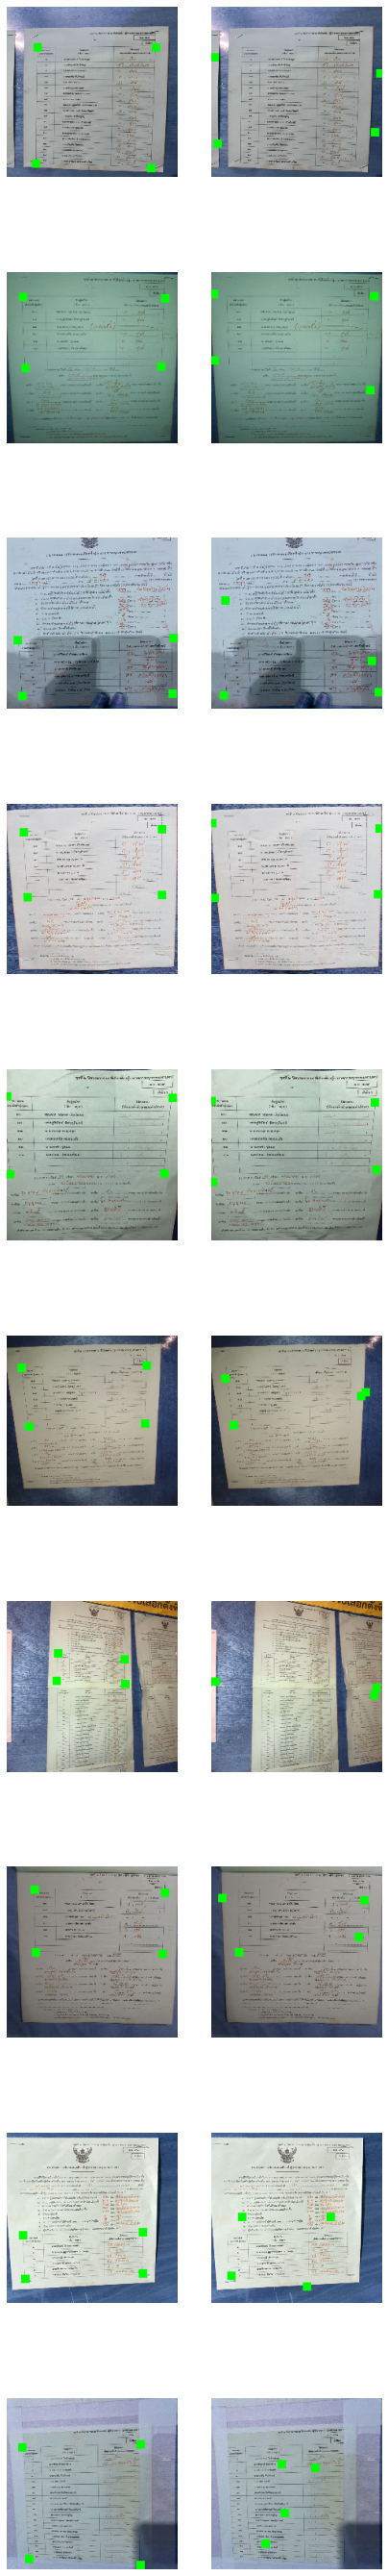

In [27]:
figs, axes = plt.subplots(nrows=10, ncols=2, figsize=(7, 50))
for ax in np.ravel(axes): ax.axis("off")
i = 0
for img, kp_true, kp_pred in zip(images, y_true.reshape(-1, 4, 2), y_preds):
    h,w,_=img.shape
    kp_true = KeypointsOnImage([Keypoint(x*w,y*h) for x, y in kp_true], shape=(h,w))
    kp_pred = KeypointsOnImage([Keypoint(x*w,y*h) for x, y in kp_pred], shape=(h,w))
    axes[i][0].imshow(kp_true.draw_on_image(img, size=10))
    axes[i][1].imshow(kp_pred.draw_on_image(img, size=10))
    i+=1
    if i>=10:break